# Tasks:
1. Evaluate the 2018 Predictions:
Using data from 2019 US wildfires, evaluate how well the 2018 predictions align with actual wildfire occurrences. The wildfire data is available from the USGS (United States Geological Survey) website.
2. Analyze Model Drift:
Compare the 2018 risk scores with the 2022 scores to assess how the model's predictions have changed over time.

This exercise is designed to evaluate your skills in:
- finding and integrating external data sources
- exploratory data analysis (EDA)
- geospatial data handling
- statistics and machine learning model valuation
- programming and communication

# Wildfire Dataset
To evaluate how well the 2018 model predicted wildfire damage, I compared the model's risk scores with actual wildfire data from 2019. The wildfire dataset, available on the [USGS website](https://www.usgs.gov/data/combined-wildfire-datasets-united-states-and-certain-territories-1878-2019).
Data includes details such as fire name, size, area, and cause.


# Solution for Q1: Evaluating 2018 Predictions
The goal is to check if the model predictions align with actual wildfire occurrences across the U.S. To do this, I determined whether each property is within a fire zone and assessed how well the model performed.

## Steps to Solve Q1:
1. Define Fire Zones:
  - Use fire polygons and create a surrounding buffer to represent fire zones.
  - Buffers estimate areas likely affected by wildfires.

2. Spatial Merging:
  - Spatial Merging:

3. Threshold for High Damage:
  - Convert risk scores into binary categories (e.g., "High Damage" = True if above the threshold).

4. Performance Metrics:
  - Evaluate the model using metrics like precision, recall, F1-score, and confusion matrix.



### Fire Zone Creation
To calculate buffer sizes, I used this formula:

```
copmpaction_value = 4 * π * Area / Length**2
buffer_d = (2 - copmpaction_value) * 2500
```
Where Area and Length are the area and length of the wildfire polygon.

compaction_value measures how compact a fire polygon is. Compact polygons (circular) have higher compaction values (1), resulting in smaller buffers and Elongated polygons have lower compaction values (<1), leading to larger buffers.

The buffer size set to have ranges between 2.5 km and 5 km, which is based on the median wildfire length (2.5 km)

This approach helps estimate the potential impact of wildfires, as larger and less compact fires are likely to affect wider areas.


### Threshold Selection
A precision-recall curve was used to choose the best threshold for "High Damage." This curve balances precision (avoiding false alarms) and recall (catching all high-risk cases). For example:
- A threshold of 4 or 5 might balance precision and recall effectively.


### Distance to Fire Polygons
To calculate the distance from each property to the nearest fire polygon:

1. If the property is inside the polygon: The distance is 0.
2. If outside: Extract the polygon's exterior vertices.
  - Find the closest vertex and calculate the distance to it.

Note: It is computationally efficient but less accurate for polygons with fewer vertices.



### Model Performance
I calculated these metrics to evaluate the model:
- Precision: How many predicted high-damage properties were correct?
- Recall: How many actual high-damage properties were detected?
- F1-Score: Balances precision and recall.
- Confusion Matrix: Summarizes true positives, false positives, etc.


Additionally:
- Log Loss: Measures prediction uncertainty. Lower values indicate more confident predictions.
- Calibration Curve: Shows how well-predicted probabilities align with actual outcomes.



-----
# Solution for Q2: Analyzing Model Drift
The aim is to analyze how the model predictions changed between 2018 and 2022 and identify trends and regions of significant changes.

## Sub-Objectives for Q2:
1. Trend Analysis:
- Compare the 2018 and 2022 scores to identify overall changes.
- Metrics:
  - Absolute Drift: The raw difference between scores.

    ```
      drift_abs = |score_2022 - score_2018|
    ```

  - Percentage Drift: Change relative to 2018 scores.

    ```
      drift_perc = (score_2022 - score_2018) / score_2018
    ```

  - Normalized Drift: Scaled difference to keep values between -1 and 1.

    ```
      normalized_drift = (scores_2022 - scores_2018) / (scores_2022 + scores_2018) * 11/9
      having 9/11 makes the normalized_drift stays between -1 and 1.
    ```
  
    - **-1**: When `scores_2018 = 10` and `scores_2022 = 1`.
    - **+1**: When `scores_2018 = 1` and `scores_2022 = 10`.
    - **0**: When `scores_2018` and `scores_2022` are equal.


This range is appropriate as scores are scaled between 1 and 10.


2. Statistical Analysis:
- Use T-tests and ANOVA to check for significant differences in means and variances.

3. Mapping Changes:
- Create maps showing areas with positive and negative changes in scores.



---
# Data Preprocessing and Cleaning

## Cleaning Prediction Data (Model prediction data: df_pred):
1. Non-Numeric Data:
   - Some predictions contain non-numeric scores. This could be due to issues with either the model or the data.
   - Proposed Solution:
     - Ignore rows with non-numeric scores.
   
2. Scores Outside the Expected Range [1-10]:
   - The model scores should fall within the range [1, 10]. However, some values are outside this range.
   - Proposed Solution:
     - Scores < 1 → Set to 1.
     - Scores > 10 → Set to 10.

3. Geographic Anomalies:
   - Two samples are outside the USA boundary!. These anomalies are likely caused by swapped latitude and longitude values.
   - Proposed Solution:**
     - Replace the latitude and longitude values for these samples rather than deleting them.

4. Empty Rows:
   - One empty row was identified and removed.


## Filtering wildfire Data (fire_2019)
- Excluded fires caused by human activities and campfires to focus on natural causes.


## Geospatial Preprocessing
- Reprojected both datasets to a metric CRS for accurate distance calculations.
- Used WGS84 CRS for visualizing data on base maps.

- for the naming of geospatial columns, the length column name shoule be less than 10! otherwise it will be truncated durin saving into shapefile. Alterbative option is saving them in other format such as geojson.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, Polygon

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, classification_report, \
log_loss, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

from sklearn.calibration import calibration_curve

from scipy.stats import ttest_rel, f_oneway

from esda.moran import Moran
from libpysal.weights import DistanceBand

import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
from IPython.display import display

from ipywidgets import interact, IntSlider

In [2]:
# Set panda display float format with two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# US wildfire shp file location
path_fire_file = 'temp/Wildfires_1878_2019_Polygon_Data/Shapefile/US_Wildfires_1878_2019.shp'

# excell and sheet name, output of the model
sheet_id = '1QjMq-88mU2ZTw8TnFQdV7-mR1xJISxQX'
sheet_name = '34324589'
url=f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_name}'

# where to save the final shape files
save_dir = 'processed_file/'

In [4]:
# read google sheet
df_pred = pd.read_csv(url)
df_pred.head(3)

,id,longitude,latitude,score_2018,score_2022
0,1.00,-86.56,35.04,1,1
1,2.00,-85.81,38.24,1,1
2,3.00,-85.70,38.11,1,1


In [5]:
# remove pnt without coordinate
df_pred = df_pred[~df_pred.longitude.isnull() & ~df_pred.latitude.isnull()]
print(df_pred.shape)

(5999, 5)


In [6]:
# find points in the latitude of 20 and 40: approximate latitude of USA
lat_usa = [20, 50]
ind = (df_pred.latitude<lat_usa[0]) | (df_pred.latitude>lat_usa[1])
print(df_pred[ind])

# correct latitude and longitude of points
df_pred.loc[ind, 'latitude'], df_pred.loc[ind, 'longitude'] =  df_pred.loc[ind, 'longitude'], df_pred.loc[ind, 'latitude']

          id  longitude  latitude score_2018 score_2022
4613 4614.00      32.50    -95.45          1          1
4879 4880.00      38.32   -122.31          3          3


In [7]:
def preprocess_score(df: pd.DataFrame, field_name: str) -> pd.DataFrame:
    """
    Normalize a numeric field in a DataFrame to ensure all values are within a range of 1 to 10.
    Any non-numeric values are converted to NaN, and values outside the range are clipped.

    Args:
        df (DataFrame): The input DataFrame containing the field to preprocess.
        field_name (str): The column name in the DataFrame to normalize.

    Returns:
        DataFrame: The DataFrame with the specified field normalized between 1 and 10.
    """
    # Convert the column to numeric, setting invalid values as NaN
    df[field_name] = pd.to_numeric(df[field_name], errors='coerce')

    # Clip values greater than 10 to 10
    df.loc[df[field_name] > 10, field_name] = 10

    # Clip values less than 1 to 1
    df.loc[df[field_name] < 1, field_name] = 1

    return df

In [8]:
# preprocess score - convert their type to number and have their range between 1 and 10
df_pred = preprocess_score(df_pred, 'score_2018')
df_pred = preprocess_score(df_pred, 'score_2022')

df_pred.head(2)

,id,longitude,latitude,score_2018,score_2022
0,1.00,-86.56,35.04,1.00,1.00
1,2.00,-85.81,38.24,1.00,1.00


In [9]:
# data summary which shows number of rows for each field and basic statistics
'''
    - all point have a latitude between 25 and 50 degree
    - scores are numbers and are between 1 and 10 
'''
df_pred.describe()

,id,longitude,latitude,score_2018,score_2022
count,5999.00,5999.00,5999.00,5996.00,5995.00
mean,3000.28,-110.40,36.19,2.44,2.52
std,1732.25,11.72,4.70,2.17,2.34
min,1.00,-124.49,25.88,1.00,1.00
25%,1500.50,-118.56,33.66,1.00,1.00
50%,3000.00,-117.02,34.46,1.00,1.00
75%,4500.50,-98.19,38.26,3.00,3.00
max,6000.00,-81.76,48.96,10.00,10.00


In [41]:
score_2018_counts = df_pred['score_2018'].value_counts().sort_index()
score_2022_counts = df_pred['score_2022'].value_counts().sort_index()

print(pd.DataFrame({
    'Score': score_2018_counts.index,
    'Count_2018': score_2018_counts.values,
    'Count_2022': score_2022_counts.reindex(score_2018_counts.index, fill_value=0).values}) )


   Score  Count_2018  Count_2022
0   1.00        3432        3418
1   2.00         706         717
2   3.00         461         459
3   4.00         309         281
4   5.00         253         248
5   6.00         252         237
6   7.00         313         270
7   8.00         244         185
8   9.00          20         105
9  10.00           6          75


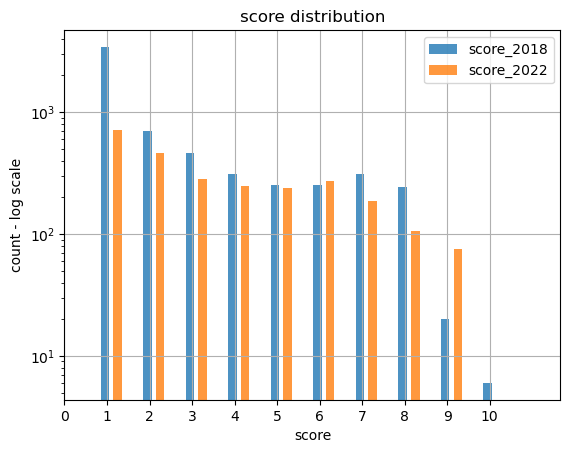

In [39]:
# Distribution comparison of the risk scores for 2018 and 2022. (The y_scale is log).
'''
    Number of samples when score is 9 and 10
'''

bins = np.arange(1, 12)

offset = 0.15

plt.hist(df_pred['score_2018'], bins=bins - offset, width=0.2, align='mid', label='score_2018', alpha=0.8)
plt.hist(df_pred['score_2022'], bins=bins + offset, width=0.2, align='mid', label='score_2022', alpha=0.8);
plt.xticks(np.arange(0, 11, 1))
plt.xlabel('score')
plt.ylabel('count - log scale')
plt.title('score distribution')
plt.grid()
plt.legend()
plt.yscale('log')

In [42]:
# create geodataframe from the processed data
df_pred = gpd.GeoDataFrame(df_pred, geometry=gpd.points_from_xy(df_pred.longitude, df_pred.latitude), crs="EPSG:4326")
df_pred.head(2)

,id,longitude,latitude,score_2018,score_2022,geometry
0,1.00,-86.56,35.04,1.00,1.00,POINT (-86.56309 35.04436)
1,2.00,-85.81,38.24,1.00,1.00,POINT (-85.8086 38.23769)


In [43]:
def load_and_filter_fire_data(file_path: str, year: int=2019) -> gpd.GeoDataFrame:
    """
    Load wildfire data from a shapefile and filter it for a specific year.
    Retains only selected relevant columns for analysis.

    Args:
        file_path (str): Path to the shapefile containing wildfire data.
        year (int - optional): The year for which wildfire data should be filtered. default it 2019

    Returns:
        GeoDataFrame: A GeoDataFrame containing filtered wildfire data with selected columns.
    """
    try:
        # Load the wildfire dataset
        fire_data = gpd.read_file(file_path, where=f'FireYear={year}')
        selected_columns = ['FireCode', 'FireName', 'FireYear', 'FireCause', 'Shape_Leng', 'Shape_Area', 'geometry']
        fire_data = fire_data[selected_columns]

        return fire_data
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

In [ ]:
# load the wildfire dataset for year 2019
fire_2019 = load_and_filter_fire_data(path_fire_file, year=2019)

fire_2019.head(2)

In [45]:
# make the coordinate system of both df_pred and fire_2009_buffer to the same coordinate system. 
df_pred = df_pred.to_crs(fire_2019.crs)

C:\Users\ataha\AppData\Local\Temp\ipykernel_12672\1450949625.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


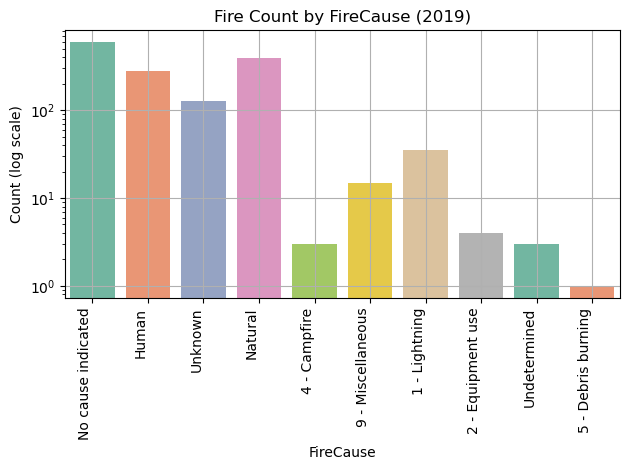

In [ ]:
# Fire count based on their cause
ax = sns.countplot(data=fire_2019, x='FireCause', hue='FireCause', palette='Set2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.set_yscale('log')
ax.set_ylabel('Count (log scale)')
ax.set_title('Fire Count by FireCause (2019)')
plt.tight_layout()
plt.grid()

In [48]:
# remove fired that casued by human and campfire as model prediction is based on wildfire 
ind = fire_2019.FireCause.isin(['Human', '4 - Campfire'])
fire_2019 = fire_2019[~ind]
fire_2019.shape

(1169, 7)

Create Fire zone by applying buffer over each polygon of the wildfire

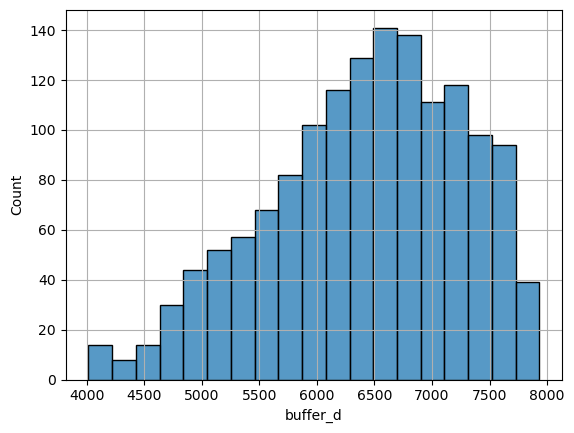

In [52]:
# Calculate buffer distances for each fire polygon based on its compactness
fire_2019['buffer_d'] = (2 - 4*np.pi*fire_2019['Shape_Area']/(fire_2019['Shape_Leng']**2 + 1e-6))*4000

# Visualize the distribution of calculated buffer distances
sns.histplot(data=fire_2019, x='buffer_d')
plt.grid()

In [53]:
# Apply buffer to each fire polygon based on the calculated 'buffer_d' distances.
# This creates a buffered geometry around each polygon.
fire_2019_buffer = fire_2019.buffer(fire_2019['buffer_d'])

# Combine all buffered polygons into a single unified geometry to avoid overlaps or duplicates.
fire_2019_buffer = gpd.GeoDataFrame(geometry=[fire_2019_buffer.union_all()], crs=fire_2019_buffer.crs)
fire_2019_buffer.head(1)

,geometry
0,"MULTIPOLYGON (((-5856803.419 -290307.468, -585..."


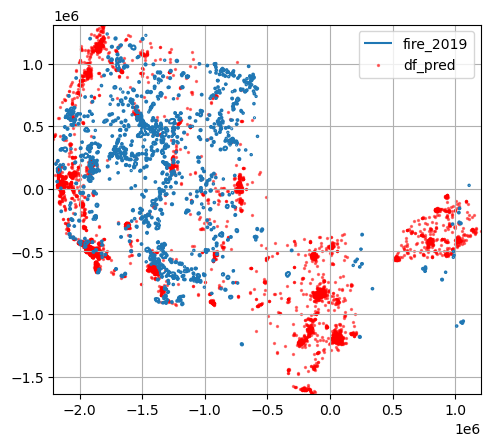

In [54]:
# Overlay two dataset to make sure data is ready for spatial analysis
fig, ax = plt.subplots()

fire_2019_buffer.boundary.plot(ax = ax)
df_pred.plot(ax=ax, color='red', alpha=0.5, markersize=2)
ax.grid()
ax.legend(['fire_2019', 'df_pred'])
bound = df_pred.total_bounds
bound[1], bound[2] = bound[2], bound[1]
ax.axis(bound);

In [ ]:
# Spatial join to determine if each property falls within the fire zone (buffered fire polygons).
df_pred['firezone19'] = gpd.sjoin(df_pred, fire_2019_buffer[['geometry']], 
                                  how='left',
                                  predicate='intersects')['index_right'].notna()

# Save the updated GeoDataFrame to a shapefile 
# df_pred.to_file(os.path.join(save_dir, 'pnt_firzone.shp'))
df_pred.head(2)

,id,longitude,latitude,score_2018,score_2022,geometry,firezone19,NFireDist,DistFire
0,1.00,-86.56,35.04,1.00,1.00,POINT (815165.69 -541833.021),False,NaN,97963.09
1,2.00,-85.81,38.24,1.00,1.00,POINT (839883.609 -162471.715),False,NaN,181995.44


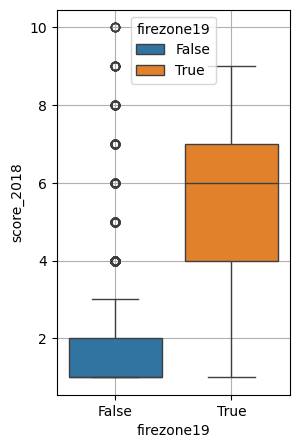

In [66]:
# BoxPlot of socre_2018 vs firezone19
fig, ax = plt.subplots(figsize=(3, 5))
sns.boxplot(data=df_pred, x='firezone19', y='score_2018', hue='firezone19');
plt.grid()

Calcuate the closest distance from the fire polygon to each property

In [108]:
def polygon_to_multipoint(polygon):
    """
    Convert the exterior boundary of a polygon to a MultiPoint geometry.
    Handles empty polygons or those without an exterior boundary gracefully.

    Args:
        polygon (Polygon): A Shapely Polygon geometry.

    Returns:
        MultiPoint: A MultiPoint geometry of the polygon's exterior boundary.
    """
    if polygon.is_empty or polygon.exterior is None:
        return MultiPoint()  # Return an empty MultiPoint for invalid polygons
    return MultiPoint(polygon.exterior.coords)


# Convert polygons to MultiPoint geometries, explode them, and build a spatial index
fire_sindex = fire_2019.explode(index_parts=True).geometry.apply(polygon_to_multipoint).explode().dropna().sindex

# Compute the nearest distance from each property point to the nearest fire vertex
# for pnt inside the polygon
points_within = gpd.sjoin(df_pred, fire_2019, how='left', predicate='within')
df_pred['DistFire'] = np.where(points_within.index_right.notna(), 0, np.nan)

# for pnt outside of the polygon
points_outside = df_pred[df_pred['DistFire'].isna()].copy()
points_outside['DistFire'] = df_pred.geometry.apply(
    lambda geom: fire_sindex.nearest(geom, return_distance=True)[1][0]  )

# update all points
df_pred.update(points_outside)

df_pred.to_file(os.path.join(save_dir, 'pnt_firzone_dist_fire.shp'))

df_pred.head(2)

,id,longitude,latitude,score_2018,score_2022,geometry,firezone19,NFireDist,DistFire
0,1.00,-86.56,35.04,1.00,1.00,POINT (815165.69 -541833.021),False,NaN,97963.09
1,2.00,-85.81,38.24,1.00,1.00,POINT (839883.609 -162471.715),False,NaN,181995.44


In [80]:
# statistics of the fire distance for each score
df_pred.groupby('score_2018').agg({'DistFire': ['count', 'mean', 'std']})

DistFire                    
              count      mean       std
score_2018                             
1.00           3432 138427.93 132757.55
2.00            706  57743.67  77173.74
3.00            461  35394.22  55800.35
4.00            309  31429.27  65488.56
5.00            253  14616.94  32805.21
6.00            252   9848.37  34809.51
7.00            313   9927.46  37000.60
8.00            244   4931.33  18260.62
9.00             20  27261.26  18033.89
10.00             6  37288.14  23121.66

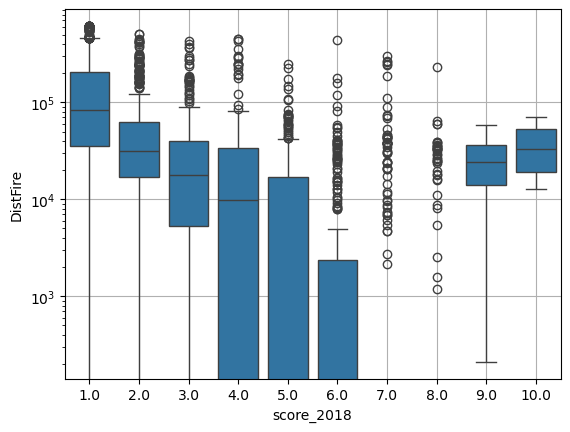

In [78]:
# Create a box plot to visualize the relationship between the 2018 risk scores ('score_2018') 
# and the nearest fire distances ('NFireDist').

sns.boxplot(data=df_pred, x='score_2018', y='DistFire')
plt.grid()
plt.yscale('log')

The results for score>6 doesnt match with the distance from the fire!!

# Calcualte Model Evaluation

In [134]:
def preprocess_pred(true, pred):
    ind = (pred>=1) & (pred<=10) & (true>=0) & (true<=10)
    return true[ind], pred[ind]

In [ ]:
pred_v = df_pred.score_2018.values.astype(int)
true_v = df_pred.firezone19.values.astype(int)

true_v, pred_v = preprocess_pred(true_v, pred_v)

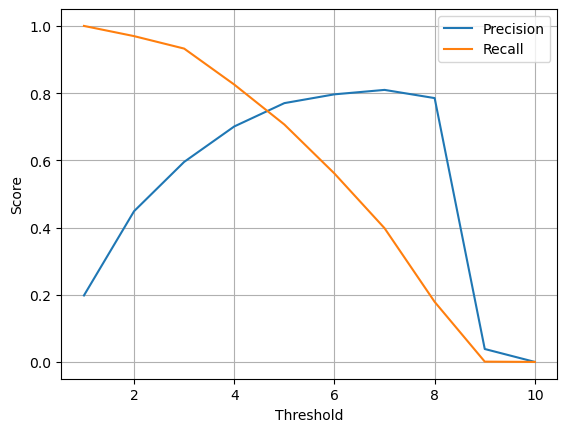

In [136]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(true_v, pred_v)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()

Based on this plot, the best threshold is 4

In [ ]:
# user can change the threshold to get different results of the classification report.
def update_classifier(th_classifier):
    """
    Updates the classification report based on the chosen threshold.
    """
    # Generate classification report
    report = classification_report(true_v, pred_v >= th_classifier)
    print(f"Classification Report for Threshold = {th_classifier}\n")
    print(report)

# Create an interactive slider for the threshold
interact(
    update_classifier,
    th_classifier = IntSlider(value=4, min=2, max=9, step=1, description="Threshold") )

interactive(children=(IntSlider(value=4, description='Threshold', max=9, min=2), Output()), _dom_classes=('wid…

<function __main__.update_classifier(th_classifier)>

threshold 4: provide precision=0.7, recall=0.83 and f1=0.76 which is the best result for the model

In [123]:
th_classifier = 4

Text(0.5, 1.0, 'Confusion Matrix - normalized')

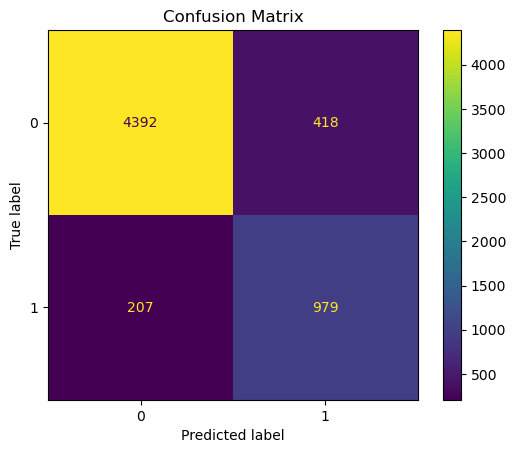

<Figure size 640x480 with 0 Axes>

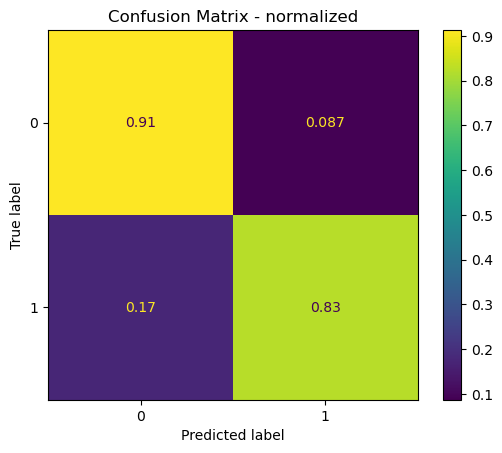

In [125]:
# Confusion matrix
conf_mat = confusion_matrix(true_v, pred_v>=th_classifier)
ConfusionMatrixDisplay(conf_mat).plot(values_format='d')
plt.title('Confusion Matrix')

plt.figure()
conf_mat = confusion_matrix(true_v, pred_v>=th_classifier, normalize='true')
ConfusionMatrixDisplay(conf_mat).plot()
plt.title('Confusion Matrix - normalized')

In [126]:
# Calculate Log Loss and Brier Score Loss without applying a threshold to the predictions:
'''
- Log Loss: Measures the uncertainty of the predictions by comparing the true values with predicted probabilities. 
    Lower values indicate better performance.
- Brier Score Loss: Evaluates the accuracy of predicted probabilities (scaled between 0 and 1),  
    where lower values indicate better calibration and accuracy.
'''


log_loss_value = log_loss(true_v, pred_v/10)
brier_score_loss_value = brier_score_loss(true_v, pred_v/10)

print(f'log_loss: {log_loss_value:1.3f}  - brier_score_loss: {brier_score_loss_value:1.3f}')

log_loss: 0.332  - brier_score_loss: 0.084


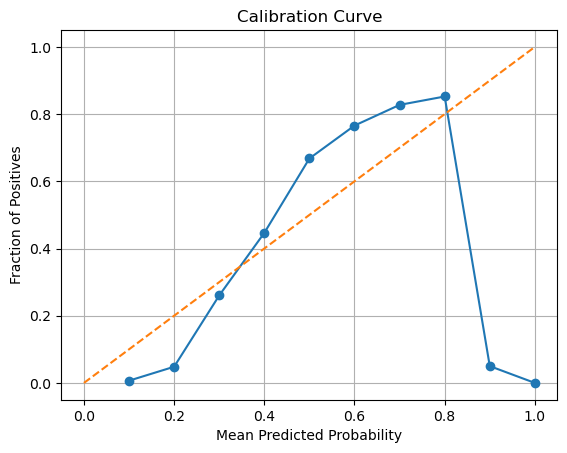

In [35]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(true_v, pred_v/10, n_bins=10)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')  # Perfect calibration
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid()

# Calculate the Model Drift

score_22 = 1.042 * score_18 + -0.027


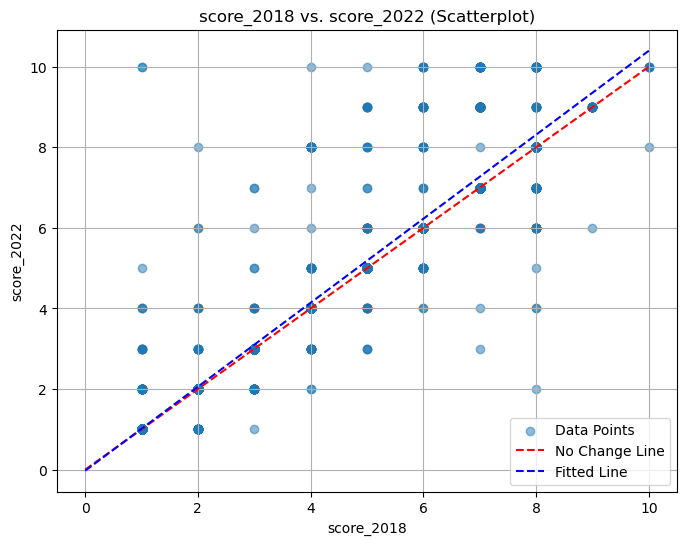

In [ ]:
# Scatterplot of score_2018 and score_2022 and their relationship

s_2018 = df_pred['score_2018'].values
s_2022 = df_pred['score_2022'].values

# only scores between 1 and 10 were considred
ind = (s_2018>=1) & (s_2022>=1) & (s_2018<=10) & (s_2022<=10)
s_2018 = s_2018[ind]
s_2022 = s_2022[ind]

# scatter plot of score_2018 and socre_2022
plt.figure(figsize=(8, 6))
plt.scatter(s_2018, s_2022, alpha=0.5, label='Data Points')
plt.plot([0, 10], [0, 10], color='red', linestyle='--', label='No Change Line')


# fit a line 
p = np.polyfit(s_2018, s_2022, 1)
x = np.linspace(0, 10, 10)
y = p[0] * x + p[1]
plt.plot(x, y, color='blue', linestyle='--', label='Fitted Line')

plt.title('score_2018 vs. score_2022 (Scatterplot)')
plt.xlabel('score_2018')
plt.ylabel('score_2022')
plt.legend()
plt.grid()

print(f'score_22 = {p[0]:1.3f} * score_18 + {p[1]:1.3f}')

This plot shows that the slope of the score_2022 increases more than 4%

In [130]:
# changes between score_2019 and s_2022
df_pred['drift'] = df_pred['score_2022'] - df_pred['score_2018']
df_pred['drift_abs'] = df_pred['drift'].abs()
df_pred['drift_perc'] = df_pred['drift'] / (df_pred['score_2018'] + 1e-3) * 100

df_pred['drift_norm'] = df_pred['drift'] / ( df_pred['score_2018'] + df_pred['score_2022'] + 1e-3)/0.82

# Metrics to see the 
mean_drift = df_pred['drift'].mean()
std_drift = df_pred['drift'].std()
max_drift = df_pred['drift'].max()

print(f'Mean Drift: {mean_drift:1.2f}')
print(f'std of Drift: {std_drift:1.2f}')
print(f'Maximum Drift: {max_drift:1.2f}')

df_pred.to_file(os.path.join(save_dir, 'pnt_drift.shp'))


Mean Drift: 0.08
std of Drift: 0.60
Maximum Drift: 9.00


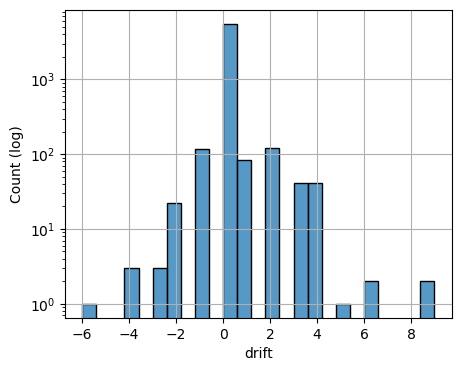

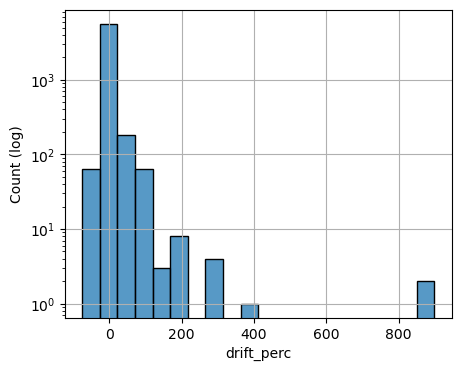

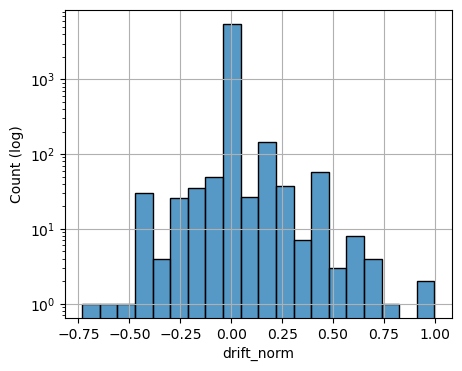

In [131]:
# distribution of all drift 
fig, ax = plt.subplots(figsize=(5,4))
sns.histplot(data=df_pred, x='drift', bins=25, ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Count (log)')
ax.grid()


fig, ax = plt.subplots(figsize=(5,4))
sns.histplot(data=df_pred, x='drift_perc', bins=20, ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Count (log)')
ax.grid()

fig, ax = plt.subplots(figsize=(5,4))
sns.histplot(data=df_pred, x='drift_norm', bins=20, ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Count (log)')
ax.grid()


Text(0, 0.5, 'score_22')

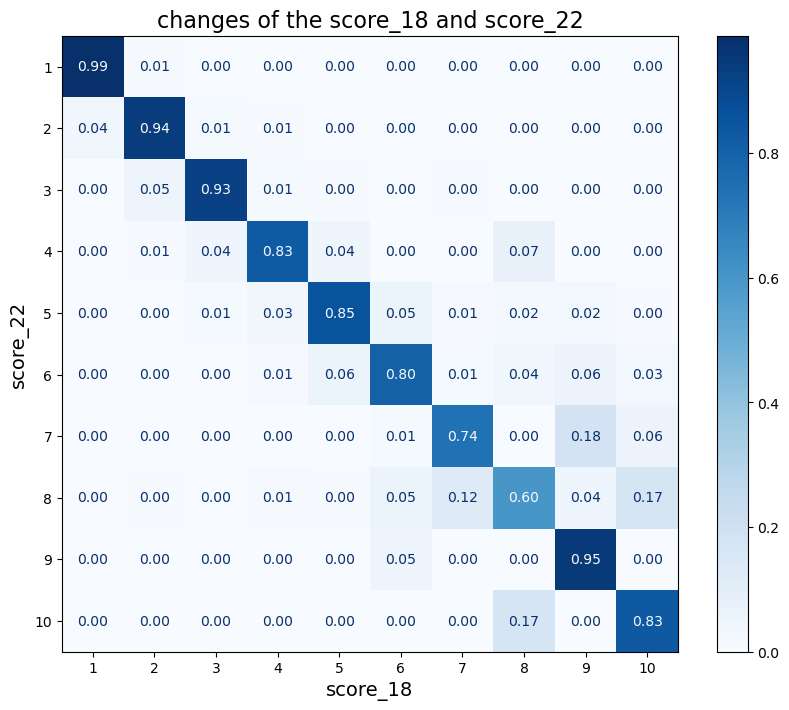

In [148]:
# confusion matix also can be used ot see the percentage of the chanegs from score_18 to score_22

score_18 = df_pred.score_2018.values
score_22 = df_pred.score_2022.values

score_18, score_22 = preprocess_pred(score_18, score_22)

fig, ax = plt.subplots(figsize=(10, 8))
conf_mat = confusion_matrix(score_18, score_22, normalize='true')
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot(cmap='Blues', ax=ax, values_format='.2f')
ax.set_xticklabels(range(1, 11))
ax.set_yticklabels(range(1, 11))
ax.set_title('changes of the score_18 and score_22', fontsize=16)
ax.set_xlabel('score_18', fontsize=14)
ax.set_ylabel('score_22', fontsize=14)

This plot illustrates the percentage of score changes between 2018 and 2022. For example:
- 40% of properties with a score of 8 in 2018 were assigned a different score in 2022, meaning 60% of them retained the same score (1 - 0.60).
- For properties with a score of 7 in 2018, 27% changed to a different score, as 74% remained unchanged (1 - 0.74).
- 1% of properties with a score of 4 in 2018 changed to a score of 8 in 2022.

This explanation highlights the proportion of score stability and shifts over time.

In [150]:
# T-test for mean 
t_stat, p_value_ttest = ttest_rel(score_18, score_22)
print('T_test', t_stat, p_value_ttest )

# ANOVA (single factor test for variance equality)
anova_stat, p_value_anova = f_oneway(score_18, score_22)
print('Annova', anova_stat, p_value_anova)

T_test -9.91594174469509 5.332172826831267e-23
Annova 3.4363184067822883 0.06380221911876172


In [151]:
# geospatail autocorrolation in the estimation of score_2018
ind = df_pred['score_2018']>=1
weights = DistanceBand.from_dataframe(df_pred[ind], threshold=50000, silence_warnings=True)

# Calculate Moran's I
moran = Moran(df_pred.loc[ind, 'score_2018'], weights)

# Print results
print(f"Moran's I: {moran.I}")
print(f"Expected I: {moran.EI}")
print(f"p-value: {moran.p_norm}")
print(f"z-score: {moran.z_norm}")

Moran's I: 0.5993750559670412
Expected I: -0.00016680567139282736
p-value: 0.0
z-score: 145.5492651978633


# Visualization of data over a basemap

In [152]:
# for visualization it is need to have the coordinate in wgs84'
df_pred = df_pred.to_crs(epsg=4326)

In [153]:
def create_point_map_gdf(gdf0, value_col, value_col_range=None,  additional_cols=None, zoom_start=6):
    """
    Create an interactive Folium map with points from a GeoDataFrame, 
    scaled and colored by a value column. Includes additional column values in the tooltip.
    
    Parameters:
        gdf (gpd.GeoDataFrame): Input GeoDataFrame with a Point geometry column.
        value_col (str): Column name for value to scale color and size.
        additional_cols (list of str): List of additional columns to show in the tooltip. Default is None.
        map_name (str): Name of the output HTML file to save the map. Default is 'point_map.html'.
        zoom_start (int): Initial zoom level of the map. Default is 10.
        
    Returns:
        folium.Map: A Folium map object.

    """
    
    gdf = gdf0.copy()
    # Initialize the map
    centroid = gdf.geometry.union_all().centroid
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=zoom_start)
    
    marker_cluster = MarkerCluster().add_to(m)
    

    if value_col_range is not None:
        ind = gdf[value_col] < value_col_range[0]
        gdf.loc[ind, value_col] = value_col_range[0]
        if ind.sum() > 0:
            print(f"Clamped {ind.sum()} values below {value_col_range[0]} to {value_col_range[0]}")
        
        ind = gdf[value_col] > value_col_range[1]
        gdf.loc[ind, value_col] = value_col_range[1]
        if ind.sum() > 0:
            print(f"Clamped {ind.sum()} values above {value_col_range[1]} to {value_col_range[1]}")
        
        vmin, vmax = value_col_range
    else:
        vmin, vmax = gdf[value_col].min(), gdf[value_col].max()
        

    color_scale = cm.LinearColormap(['blue', 'yellow', 'red'], 
                                    vmin=vmin, 
                                    vmax=vmax)
    
    # add color legend
    color_scale.caption = f"{value_col} Color Scale"
    color_scale.add_to(m)

    # Add each point to the map
    for _, row in gdf.iterrows():
        coords = (row.geometry.y, row.geometry.x)  # Latitude, Longitude

        # Build the tooltip with the value column and additional columns
        tooltip_content = f"<b>{value_col}:</b> {row[value_col]:1.2f}"
        if additional_cols:
            for col in additional_cols:
                tooltip_content += f"<br><b>{col}:</b> {row[col]:1.1f}"


        folium.CircleMarker(
            location=coords,
            radius=8,
            color='black',
            fill=True,
            fill_color=color_scale(row[value_col]),
            fill_opacity=0.8,
            tooltip=folium.Tooltip(tooltip_content)
        ).add_to(marker_cluster)
    
    return m

In [154]:
# list and map of the points that has a drif_abs > 3
ind = df_pred.drift_abs>3

create_point_map_gdf(df_pred[ind], 'drift', value_col_range=[-3, 3], additional_cols=['score_2018', 'score_2022', 'NFireDist'], zoom_start=6)

Clamped 4 values below -3 to -3
Clamped 46 values above 3 to 3


In [157]:
# Identify locations where changes occurred between 'score_2018' and 'score_2022'.
# - The condition checks two criteria:
#   1. 'score_2022' is not equal to 'score_2018', indicating a difference between the two scores.
#   2. 'norm_drif' (normalized drift) is greater than -1, ensuring only valid changes are included.

ind = (df_pred.score_2022!=df_pred.score_2018) & (df_pred.drift_norm>-1)

create_point_map_gdf(df_pred[ind], 'drift_norm', value_col_range=[-0.5, 0.5], additional_cols=['score_2018', 'score_2022', 'DistFire'], zoom_start=6)

Clamped 2 values below -0.5 to -0.5
Clamped 16 values above 0.5 to 0.5


# Conclusion
## **Model Performance Analysis**

The model's performance was evaluated using several metrics to assess its accuracy, precision, and confidence in predictions. Below are the detailed findings:


**1. Classification Metrics**
To assess the model's ability to categorize properties as high or low damage based on a threshold, the following metrics were calculated:

**Optimal Threshold**
- A threshold of **4** was identified as the optimal cutoff for categorizing scores.
- This threshold provides the best balance of precision, recall, and F1-score:
  - **Precision**: 0.70  
    - *70% of properties predicted as high damage were actually high damage.*
  - **Recall**: 0.83  
    - *83% of all actual high-damage properties were correctly identified by the model.*
  - **F1-Score**: 0.76  
    - *The harmonic mean of precision and recall indicates the model performs well in balancing false positives and false negatives.*



**2. Confidence Metrics**
The model’s overall prediction confidence was evaluated using the **Log Loss** and **Brier Score Loss**:

**Log Loss**: 0.332  
- *Measures the uncertainty of predictions by penalizing incorrect predictions based on their confidence.*
- A lower value indicates better confidence in predictions, with **0.332** suggesting moderate confidence.

**Brier Score Loss**: 0.084  
- *Evaluates the accuracy of probabilistic predictions by comparing predicted probabilities with actual outcomes.*
- A score of **0.084** reflects relatively good calibration, meaning the predicted probabilities closely match observed outcomes.



**3. Calibration Curve Insights**
The calibration curve provided additional insights into the model’s confidence:

- For probabilities **below 0.4**, the model is **overconfident**, assigning high probabilities to incorrect predictions.
- For probabilities **above 0.4**, the model is **underconfident**, assigning lower probabilities to correct predictions.
- At probabilities **≥ 0.8**, the model again shows **overconfidence**, potentially overestimating certain outcomes.


**4. Spatial and Proximity Analysis**
The model incorporates spatial features by analyzing proximity to fire zones:
- Properties with higher scores (`score_2018 >= 5`) were found to be, on average, **17 km** from the nearest fire zone, reflecting some alignment with real-world fire patterns.


### **Potential Improvements**
1. Address class imbalance in the dataset to improve precision and recall for less-represented scores.
2. Use additional environmental features (e.g., drought indices, temperature anomalies) to enhance predictive power.
3. Refine calibration, particularly for probabilities below **0.4** and above **0.8**, to improve confidence alignment.
4. Strong positive spatial autocorrelation in `score_2018` indicates that properties with similar scores are geographically clustered, which may reflect underlying spatial trends in wildfire risks.


----

# **Drift Analysis**

## **Scatter Plot Analysis**
The scatter plot comparing `score_2018` and `score_2022` reveals the following trend:
- The slope of the scores in 2022 increases by **4%**, indicating a slight upward trend in model predictions over time.


## **Drift Statistics**
The drift between `score_2018` and `score_2022` was analyzed quantitatively:
- **Mean Drift**: Increased by **0.08**, with a standard deviation of **0.6**.
- **Maximum Drift**: The largest observed drift was **9**, indicating significant score changes for some properties.


## **Score Stability and Changes**
An analysis of score changes between 2018 and 2022 reveals the following:
- **40%** of properties with a score of 8 in 2018 were assigned a different score in 2022, meaning **60%** retained the same score.
- For properties with a score of 7 in 2018, **27%** changed to a different score, while **74%** remained unchanged.
- **1%** of properties with a score of 4 in 2018 changed to a score of 8 in 2022.

This analysis highlights the degree of score stability and shifts over time, with some scores exhibiting more variability than others.



## **Statistical Tests**
To assess significant differences between scores in 2018 and 2022, the following tests were conducted:
- **T-Test**:
  - Test Statistic: **-9.92**
  - p-value: **5.33e-23**  
  - *Interpretation*: The extremely small p-value indicates statistically significant differences between the scores.

- **ANOVA**:
  - F-Statistic: **3.44**
  - p-value: **0.0638**  
  - *Interpretation*: While the ANOVA test suggests some variance between the groups, the p-value is slightly above the standard significance threshold of 0.05.



## **Geospatial Autocorrelation**
To evaluate spatial patterns in the estimation of `score_2018`, Moran’s I test was conducted. The results are as follows:
- **Moran’s I**: **0.5994**  
  - *Interpretation*: Indicates a strong positive spatial autocorrelation, meaning properties with similar scores tend to cluster spatially.
- **Expected I**: **-0.0002**  
- **p-value**: **0.0**  
  - *Interpretation*: The near-zero p-value confirms that the observed spatial autocorrelation is highly significant.
- **z-score**: **145.55**  
  - *Interpretation*: The high z-score further supports the presence of significant spatial clustering.



1. The model shows a slight upward trend in predictions for 2022 compared to 2018, with notable changes in certain scores.
2. Statistical tests confirm significant differences between 2018 and 2022 scores, though ANOVA results suggest only marginal variance across groups.